Introduction:


In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
#os.chdir('C:/Users/Krishna/OneDrive/Krishna/Coursework/STAT542/Ind_project/wine-reviews') #desktop

os.chdir('C:/Users/krish/OneDrive/Krishna/Coursework/STAT542/Ind_project/wine-reviews') #laptop


In [3]:
#parsing the input data
inp_data=pd.read_csv('inp_data.csv')


In [4]:
proc_data=inp_data.drop_duplicates(subset='description', keep="first")
proc_data=proc_data.dropna(subset=['price','description','points'])
proc_data=proc_data.reset_index(drop=True)

#transforming the description to a vector so that it can be applied into classification

To transform the review sentence to a vector, I will be using the word2vec package with the pre-trained GLoVE features

In [ ]:
#os.chdir('C:/Users/Krishna/Desktop/ind_project/glove.6B') #desktop
os.chdir('C:/Users/krish/Desktop/ind_proj_542/glove.6B')
from gensim.scripts.glove2word2vec import glove2word2vec 
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)


In [25]:
import re
import time
import numpy as np
X=proc_data['description']

result_array=[]

t1=time.time()
for i in range(1,len(X)):
    
    x_strip=re.sub(r'[^\w\s]','',X[i]) #strip the punctuation so that every word can fit into 
    
    list_token=x_strip.split()
    token_vec=np.zeros(100)

    for j in range(1,len(list_token)):
        
        if list_token[j] in model.vocab:
            
            token_vec=token_vec+model.get_vector(list_token[j])
            
        else:
            
            token_vec=token_vec
        
    token_vec=(token_vec.reshape(-1,1))/len(list_token)
    
    token_vec=token_vec.squeeze()
    
    result_array.append(token_vec)
     
t2=time.time()

result_df=pd.DataFrame(result_array)    

result_df.to_csv('word2vec.csv')   

total_time=t2-t1



In [26]:
col_names=['desc'+str(id) for id in range(0,100)]

len(col_names)
result_df.columns=col_names


In [27]:
result_df.head()

,desc0,desc1,desc2,desc3,desc4,desc5,desc6,desc7,desc8,desc9,...,desc90,desc91,desc92,desc93,desc94,desc95,desc96,desc97,desc98,desc99
0,-0.362887,0.118834,0.121537,-0.224149,0.205286,0.193360,0.084521,0.092894,-0.161100,0.094909,...,-0.046470,-0.099519,-0.548903,0.059477,-0.452476,-0.154325,-0.354054,-0.389441,0.353290,0.382224
1,-0.253057,0.151647,0.153212,-0.168652,0.127654,0.203803,0.030083,0.180260,-0.099923,0.082560,...,0.010657,-0.080923,-0.483043,0.008327,-0.387595,-0.189706,-0.237476,-0.293652,0.324201,0.226057
2,-0.210210,0.289732,0.378851,-0.190696,0.031599,0.230219,-0.001175,0.165531,-0.220034,0.097913,...,0.031133,-0.074001,-0.231279,0.042580,-0.398206,-0.127425,-0.351018,-0.313840,0.392551,0.319700
3,-0.275772,0.251431,0.174424,-0.204858,0.095742,0.165586,0.056073,0.095629,-0.186938,0.043971,...,-0.045437,-0.058307,-0.399959,0.040815,-0.325528,0.003764,-0.403655,-0.379357,0.385304,0.280184
4,-0.371475,0.230490,0.067625,-0.190724,0.142736,0.176915,0.018682,0.119093,-0.221796,0.061063,...,0.004816,-0.124494,-0.476763,0.031008,-0.407745,-0.055311,-0.472458,-0.362337,0.380859,0.294100


Intuitively, most influential variables seem to be the country of origin, review given by a taster, price, name of the taster and the variety of the wine. Performing some exploratory data analysis to check if these variables actually have an effect.

Dropping the columns that we're not interested in:

In [28]:
proc_data_red=proc_data.drop(['designation', 'description','points',  'province',
       'region_1', 'region_2', 'taster_twitter_handle', 'title',
        'winery'], axis=1)

In [29]:
features = pd.get_dummies(proc_data_red)


In [30]:
final_feat=pd.concat([features,result_df], axis=1)

In [31]:
final_feat=final_feat.fillna(0)

In [32]:
y=proc_data['points']


In [84]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
#from sklearn.svm import SVR
#from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb 
import catboost as ctb



X_train, X_test, y_train, y_test = train_test_split(final_feat, y, test_size=0.1, random_state=1)


In [102]:
#model=Ridge(alpha=0.1)
#model = SVR(gamma='scale', C=1.0, epsilon=0.2)
model=LinearRegression()
#model = RandomForestRegressor()
#model=xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                #max_depth = 5, alpha = 10, n_estimators = 100)
    
#model=ctb.CatBoostRegressor(iterations=500, learning_rate=0.1,depth=10, verbose=False)

model.fit(X_train,y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [106]:
alphas=np.array([1,0.1,0.01,0.001,0.0001,0])

model=Ridge()

grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

grid.fit(X_train,y_train)

C:\Users\Krishna\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 0.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [103]:
y_pred=model.predict(X_test)

In [104]:
mse=sum((np.array(y_test).astype(float)-y_pred)**2)/(len(y_test))
mse**0.5

2.303547353467835

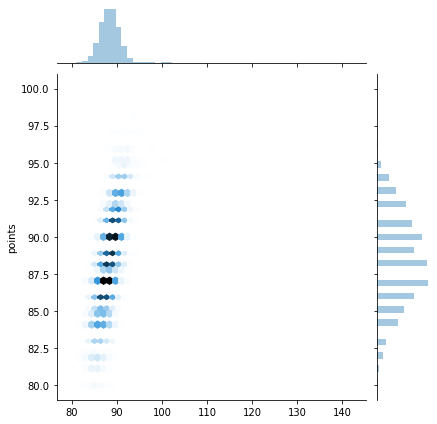

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.jointplot(y_pred,y_test, kind="hex")

#plt.plot(y_pred,y_test,'ro')
#plt.show()

Part2) To give a rating